# Import Library

In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
from google.colab import files
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Concatenate, Attention, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from gensim.models import FastText
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from Levenshtein import distance as levenshtein_distance

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Understanding

In [ ]:
'''
Get The Data - All Language
'''

data = drive.CreateFile({'id':'1ACNH6riCVczdndxwhfVL98UOuu_Fjndp'})
data.GetContentFile('Jawa-Sunda.csv')

In [ ]:
df = pd.read_csv('Jawa-Sunda.csv')
df.head()

,language,pegon,latin
0,Jawa,تاريخ,tariḵ
1,Jawa,والى,wali
2,Jawa,سڠا,sṅa
3,Jawa,نࣤرَاڠَاكࣤنْ,něraṅakěn
4,Jawa,بَبَادْاِيْفُونْ,babadipun


In [ ]:
df_jawa = df[df['language'] == 'Jawa']
df_jawa

,language,pegon,latin
0,Jawa,تاريخ,tariḵ
1,Jawa,والى,wali
2,Jawa,سڠا,sṅa
3,Jawa,نࣤرَاڠَاكࣤنْ,něraṅakěn
4,Jawa,بَبَادْاِيْفُونْ,babadipun
...,...,...,...
3235,Jawa,وَاٰلِهِ,waālihi
3236,Jawa,وَصَحْبِهِ,waṣaẖbihi
3237,Jawa,لِلَّهِ,lillahi
3238,Jawa,بشْرى,bśr


In [ ]:
'''
Split Train and Testing Data
'''

train_df, test_df = train_test_split(df_jawa, test_size=0.1, random_state=42)

print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (2234, 3)
Shape of testing set: (249, 3)


# Data Preprocessing

In [ ]:
def preprocess(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '\t' + str(x).lower() + '\n')
    return df

In [ ]:
'''
Convert to Lower Case and Add Start and End Token of the Latin Words
'''

train_df = preprocess(train_df, 'latin')
train_df.head()

,language,pegon,latin
1811,Jawa,بَنْتُوَانَىْ,\tbantuane\n
2752,Jawa,يَينْ,\tyen\n
1435,Jawa,فَورْتࣤڮِيْس,\tfortěgis\n
2693,Jawa,اِنْدُوْنِيْسِيَا,\tindunisia\n
1456,Jawa,تِمْبُوْلَىْ,\ttimbule\n


In [ ]:
def train_fasttext_model(sentences, window=7, epochs=150, min_count=0, sg=1):
    model = FastText(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        epochs=epochs,
        min_count=min_count,
        sg=sg
    )
    return model

In [ ]:
def create_tokenizer(column_data):
    # Create a tokenizer for character-level tokenization
    tokenizer = Tokenizer(char_level=True)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(column_data)

    return tokenizer

In [ ]:
def create_input_sequences(column_data, tokenizer):
    # Get the size of the vocabulary (number of unique characters) plus one for padding
    char_size = len(tokenizer.word_index) + 1

    # Encode the text data into sequences of integers
    encoded = tokenizer.texts_to_sequences(column_data)

    # Find the maximum sequence length
    max_len = max(len(seq) for seq in encoded)

    # Pad the sequences to ensure uniform length
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return char_size, encoded, max_len, padded

In [ ]:
# Create Pegon Character Tokenizer
pegon_tokenizer = create_tokenizer(train_df['pegon'])

# Create Latin Character Tokenizer
latin_tokenizer = create_tokenizer(train_df['latin'])

In [ ]:
# Create Input Sequences of Pegon Words
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(train_df['pegon'], pegon_tokenizer)

# Create Input Sequences of Latin Words
latin_char_size, latin_encoded, latin_max_len, padded_latin = create_input_sequences(train_df['latin'], latin_tokenizer)

In [ ]:
'''
Save Tokenizer
'''

filename = 'pegon_tokenizer_5.pkl'
pickle.dump(pegon_tokenizer, open(filename, 'wb'))
files.download('pegon_tokenizer_5.pkl')

filename = 'latin_tokenizer_5.pkl'
pickle.dump(latin_tokenizer, open(filename, 'wb'))
files.download('latin_tokenizer_5.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
Latin Token Index
'''

latin_index = latin_tokenizer.word_index
latin_df = pd.DataFrame(list(latin_index.items()), columns=['Char', 'Index'])
latin_df.set_index('Char', inplace=True)
latin_df

,Index
Char,
a,1
\t,2
\n,3
i,4
n,5
u,6
r,7
ě,8
m,9


In [ ]:
'''
Pegon Token Index
'''

pegon_index = latin_tokenizer.word_index
pegon_df = pd.DataFrame(list(pegon_index.items()), columns=['Char', 'Index'])
pegon_df.set_index('Char', inplace=True)
pegon_df

,Index
Char,
a,1
\t,2
\n,3
i,4
n,5
u,6
r,7
ě,8
m,9


In [ ]:
'''
Check All of Variables
'''

print("Number of characters in Pegon:", pegon_char_size)
print("Number of characters in Latin:", latin_char_size)

print()

print("Example of Encoded Pegon:", pegon_encoded[0])
print("Example of Encoded Latin:", latin_encoded[0])

print()

print("Max Length of Encoded Pegon Sequences:", pegon_max_len)
print("Max Length of Encoded Latin Sequences", latin_max_len)


print()

print("Example of Encoded Pegon with Padding:", padded_pegon[0])
print("Example of Encoded Latin with Padding:", padded_latin[0])

Number of characters in Pegon: 66
Number of characters in Latin: 57

Example of Encoded Pegon: [19, 2, 6, 1, 17, 7, 4, 2, 3, 6, 2, 16, 1]
Example of Encoded Latin: [2, 16, 1, 5, 11, 6, 1, 5, 15, 3]

Max Length of Encoded Pegon Sequences: 21
Max Length of Encoded Latin Sequences 15

Example of Encoded Pegon with Padding: [19  2  6  1 17  7  4  2  3  6  2 16  1  0  0  0  0  0  0  0  0]
Example of Encoded Latin with Padding: [ 2 16  1  5 11  6  1  5 15  3  0  0  0  0  0]


In [ ]:
'''
Train fastText model both Latin and Pegon
'''

vector_size = 300

pegon_vectorizer = train_fasttext_model(df['pegon'], vector_size)
latin_vectorizer = train_fasttext_model(df['latin'], vector_size)

In [ ]:
def create_embedding_matrix(tokenizer, vectorizer):
    # Initialize embedding matrix
    char_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((char_size, vectorizer.vector_size))

    # Fill embedding matrix
    for char, i in tokenizer.word_index.items():
        embedding_vector = vectorizer.wv[char]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
'''
Create the Embedding Matrix for both Pegon and Latin
'''

pegon_emb_mat = create_embedding_matrix(pegon_tokenizer, pegon_vectorizer)
latin_emb_mat = create_embedding_matrix(latin_tokenizer, latin_vectorizer)


print("Example of Pegon Embedding Matrix:\n", pegon_emb_mat)
print("Example of Latin Embedding Matrix:\n", latin_emb_mat)

Example of Pegon Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0192399   0.09042642  0.00494354 ...  0.01595853  0.08055749
  -0.07805996]
 [ 0.05727967  0.09439416 -0.02610954 ... -0.01913591  0.03016664
  -0.00498243]
 ...
 [ 0.01284327  0.0752964   0.03748619 ...  0.02915078  0.07427074
  -0.00491685]
 [-0.12914623  0.22364302  0.06555416 ... -0.11019678  0.01049855
  -0.15546578]
 [-0.07869481 -0.0182011   0.12295066 ...  0.06821031 -0.12817864
  -0.05502311]]
Example of Latin Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.01127723 -0.04049693  0.03278895 ... -0.01203205  0.00951685
  -0.02235522]
 [-0.00063902  0.00246553 -0.00065751 ...  0.00165612  0.0028372
  -0.00297938]
 ...
 [ 0.09776302  0.1739437   0.06070014 ...  0.06395239  0.04207157
  -0.06325323]
 [ 0.10592745 -0.05494928  0.07962514 ...  0.13659529  0.21315169
  -0.04502023]
 [ 0.1549304   0.0026963   0.09414703 ...  

# Modelling

In [ ]:
'''
Split Train and Validation Data
'''

X_train, X_val, y_train, y_val = train_test_split(padded_pegon, padded_latin, test_size=0.1, random_state=42)

print("Shape of Pegon Train:", X_train.shape)
print("Shape of Latin Train:", y_train.shape)
print("Shape of Pegon Validation:", X_val.shape)
print("Shape of Latin Validation:", y_val.shape)

Shape of Pegon Train: (2010, 21)
Shape of Latin Train: (2010, 15)
Shape of Pegon Validation: (224, 21)
Shape of Latin Validation: (224, 15)


In [ ]:
def create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [ ]:
def create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_outputs, forward_h, backward_h = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_outputs, _ = GRU(latent_dim*2, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [ ]:
def create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [ ]:
def create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, backward_h = encoder_gru(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [ ]:
def compile_model(model):
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

In [ ]:
def train_model(model, X_train, X_val, y_train, y_val, epochs=100, batch_size=64, patience=5):
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                        callbacks=[early_stopping])

    training_time_seconds = time.time() - start_time
    training_time_minutes = training_time_seconds / 60.0
    print(f"Training time: {training_time_minutes:.2f} minutes")

    return model, training_time_minutes, history

## Create Model

In [ ]:
'''
Create bilstm_att Seq2Seq Model
'''

bilstm_att = create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bilstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 21, 512)              33792     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 21, 1024),           4198400   ['embedding[0][0]']           
 al)                          (None, 512),                                                    

In [ ]:
'''
Create bigru_att Seq2Seq Model
'''

bigru_att = create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bigru_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 21, 512)              33792     ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 21, 1024),           3151872   ['embedding_2[0][0]']         
 onal)                        (None, 512),                                                  

In [ ]:
'''
Create fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att = create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bilstm_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 21, 300)              19800     ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  [(None, 21, 1024),           3330048   ['embedding_4[0][0]']         
 onal)                        (None, 512),                                                  

In [ ]:
'''
Create fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att = create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bigru_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 21, 300)              19800     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  [(None, 21, 1024),           2500608   ['embedding_6[0][0]']         
 onal)                        (None, 512),                                                  

## Training Model

In [ ]:
'''
Train bilstm_att Seq2Seq Model
'''

bilstm_att, bilstm_att_training_time, bilstm_att_history = train_model(bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 104s 3s/step - loss: 0.0293 - accuracy: 0.9934 - val_loss: 0.0745 - val_accuracy: 0.9818
Epoch 2/100
32/32 [==============================] - 93s 3s/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0494 - val_accuracy: 0.9863
Epoch 3/100
32/32 [==============================] - 90s 3s/step - loss: 0.0137 - accuracy: 0.9967 - val_loss: 0.0445 - val_accuracy: 0.9892
Epoch 4/100
32/32 [==============================] - 89s 3s/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0450 - val_accuracy: 0.9895
Epoch 5/100
32/32 [==============================] - 89s 3s/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.0821 - val_accuracy: 0.9825
Epoch 6/100
32/32 [==============================] - 90s 3s/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0570 - val_accuracy: 0.9853
Epoch 7/100
32/32 [==============================] - 90s 3s/step - loss: 0.0087 - accuracy: 0.9983 - val_loss: 0.0493 - val_accuracy: 0.9872
Epoch 8/100


In [ ]:
'''
Train bigru_att Seq2Seq Model
'''

bigru_att, bigru_att_training_time, bigru_att_history = train_model(bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 71s 2s/step - loss: 1.8736 - accuracy: 0.5523 - val_loss: 1.4787 - val_accuracy: 0.6148
Epoch 2/100
32/32 [==============================] - 62s 2s/step - loss: 1.2842 - accuracy: 0.6490 - val_loss: 1.0754 - val_accuracy: 0.7194
Epoch 3/100
32/32 [==============================] - 63s 2s/step - loss: 0.7449 - accuracy: 0.8113 - val_loss: 0.4446 - val_accuracy: 0.8986
Epoch 4/100
32/32 [==============================] - 61s 2s/step - loss: 0.3096 - accuracy: 0.9236 - val_loss: 0.2156 - val_accuracy: 0.9439
Epoch 5/100
32/32 [==============================] - 62s 2s/step - loss: 0.1214 - accuracy: 0.9709 - val_loss: 0.1478 - val_accuracy: 0.9652
Epoch 6/100
32/32 [==============================] - 63s 2s/step - loss: 0.0843 - accuracy: 0.9792 - val_loss: 0.1306 - val_accuracy: 0.9675
Epoch 7/100
32/32 [==============================] - 61s 2s/step - loss: 0.0681 - accuracy: 0.9829 - val_loss: 0.0826 - val_accuracy: 0.9754
Epoch 8/100
3

In [ ]:
'''
Train fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history = train_model(fasttext_bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 115s 3s/step - loss: 2.0072 - accuracy: 0.5283 - val_loss: 1.6629 - val_accuracy: 0.5619
Epoch 2/100
32/32 [==============================] - 64s 2s/step - loss: 1.4592 - accuracy: 0.6111 - val_loss: 1.3806 - val_accuracy: 0.6253
Epoch 3/100
32/32 [==============================] - 66s 2s/step - loss: 1.2416 - accuracy: 0.6560 - val_loss: 1.0987 - val_accuracy: 0.7022
Epoch 4/100
32/32 [==============================] - 66s 2s/step - loss: 0.9458 - accuracy: 0.7475 - val_loss: 0.7453 - val_accuracy: 0.8087
Epoch 5/100
32/32 [==============================] - 66s 2s/step - loss: 0.5694 - accuracy: 0.8612 - val_loss: 0.4173 - val_accuracy: 0.8960
Epoch 6/100
32/32 [==============================] - 68s 2s/step - loss: 0.3043 - accuracy: 0.9260 - val_loss: 0.2522 - val_accuracy: 0.9359
Epoch 7/100
32/32 [==============================] - 67s 2s/step - loss: 0.2144 - accuracy: 0.9438 - val_loss: 0.1997 - val_accuracy: 0.9531
Epoch 8/100


In [ ]:
'''
Train fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history = train_model(fasttext_bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 55s 2s/step - loss: 2.1249 - accuracy: 0.5120 - val_loss: 1.6280 - val_accuracy: 0.5813
Epoch 2/100
32/32 [==============================] - 46s 1s/step - loss: 1.4080 - accuracy: 0.6318 - val_loss: 1.2601 - val_accuracy: 0.6553
Epoch 3/100
32/32 [==============================] - 46s 1s/step - loss: 1.0977 - accuracy: 0.6957 - val_loss: 0.9355 - val_accuracy: 0.7490
Epoch 4/100
32/32 [==============================] - 46s 1s/step - loss: 0.7536 - accuracy: 0.8087 - val_loss: 0.5111 - val_accuracy: 0.8756
Epoch 5/100
32/32 [==============================] - 47s 1s/step - loss: 0.3754 - accuracy: 0.9073 - val_loss: 0.2594 - val_accuracy: 0.9346
Epoch 6/100
32/32 [==============================] - 47s 1s/step - loss: 0.2439 - accuracy: 0.9351 - val_loss: 0.1848 - val_accuracy: 0.9576
Epoch 7/100
32/32 [==============================] - 48s 1s/step - loss: 0.1217 - accuracy: 0.9716 - val_loss: 0.1511 - val_accuracy: 0.9630
Epoch 8/100
3

# Model Evaluation

In [ ]:
def evaluate_model(model, X_val, y_val):
    evaluation_result = model.evaluate([X_val, y_val[:, :-1]], y_val[:, 1:])
    loss = evaluation_result[0]
    accuracy = evaluation_result[1]

    return loss, accuracy

In [ ]:
'''
Evaluate Model
'''

models = {
    'bilstm_att': [bilstm_att, bilstm_att_training_time, bilstm_att_history],
    'bigru_att': [bigru_att, bigru_att_training_time, bigru_att_history],
    'fasttext_bilstm_att': [fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history],
    'fasttext_bigru_att': [fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history]
}

evaluation_results = []

for model_name, values in models.items():
    model = values[0]
    training_time = values[1]
    history = values[2]
    loss, accuracy = evaluate_model(model, X_val, y_val)
    evaluation_results.append({
        'Model': model_name,
        'Loss': loss,
        'Accuracy': accuracy,
        'Epochs' : len(history.history['loss']),
        'Avg Training Time (m)': round(training_time/len(history.history['loss']), 2),
        'Total Training Time (m)': round(training_time, 2)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

7/7 [==============================] - 2s 219ms/step - loss: 0.0525 - accuracy: 0.9853


,Model,Loss,Accuracy,Epochs,Avg Training Time (m),Total Training Time (m)
0,bilstm_att,0.044525,0.989158,8,1.53,12.24
1,bigru_att,0.039741,0.990434,21,1.05,22.02
2,fasttext_bilstm_att,0.085377,0.979911,17,1.15,19.61
3,fasttext_bigru_att,0.052469,0.985332,30,0.82,24.66


In [ ]:
def plot_loss_accuracy(model_name, history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', None)
    val_accuracy = history.history.get('val_accuracy', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

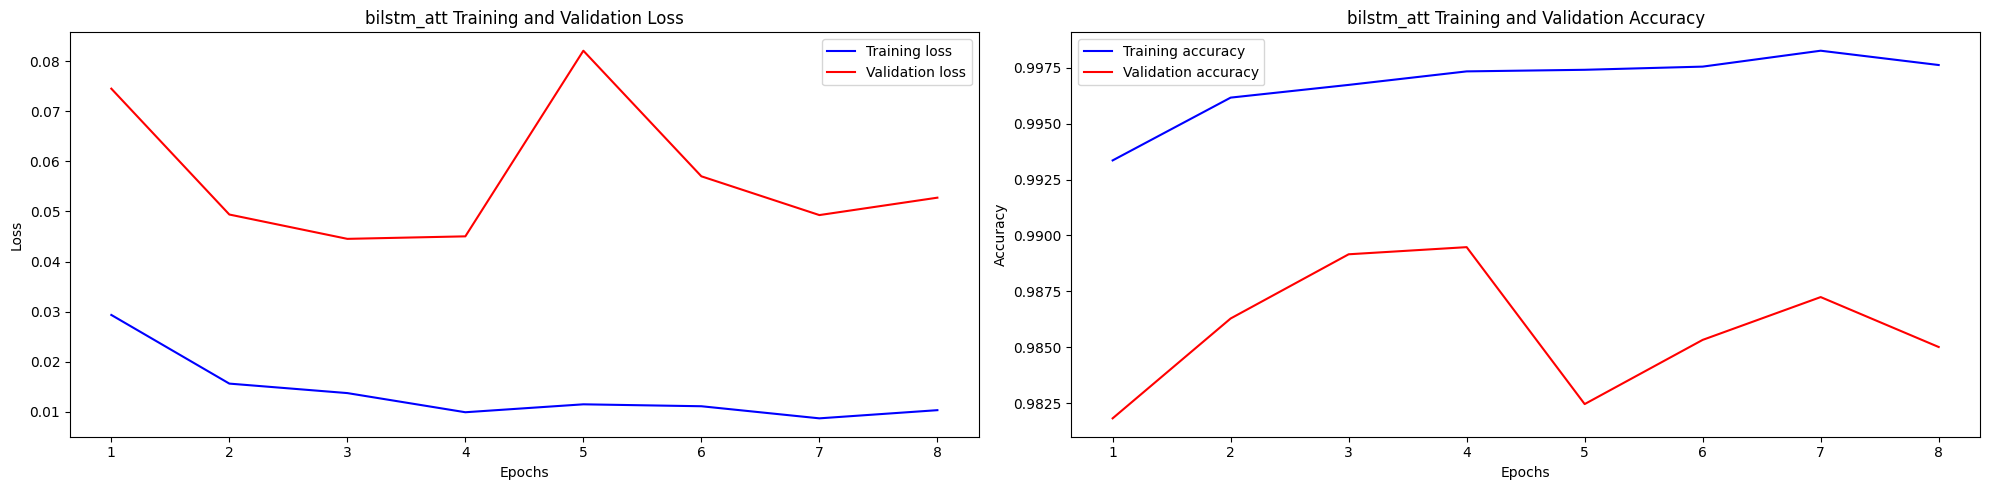

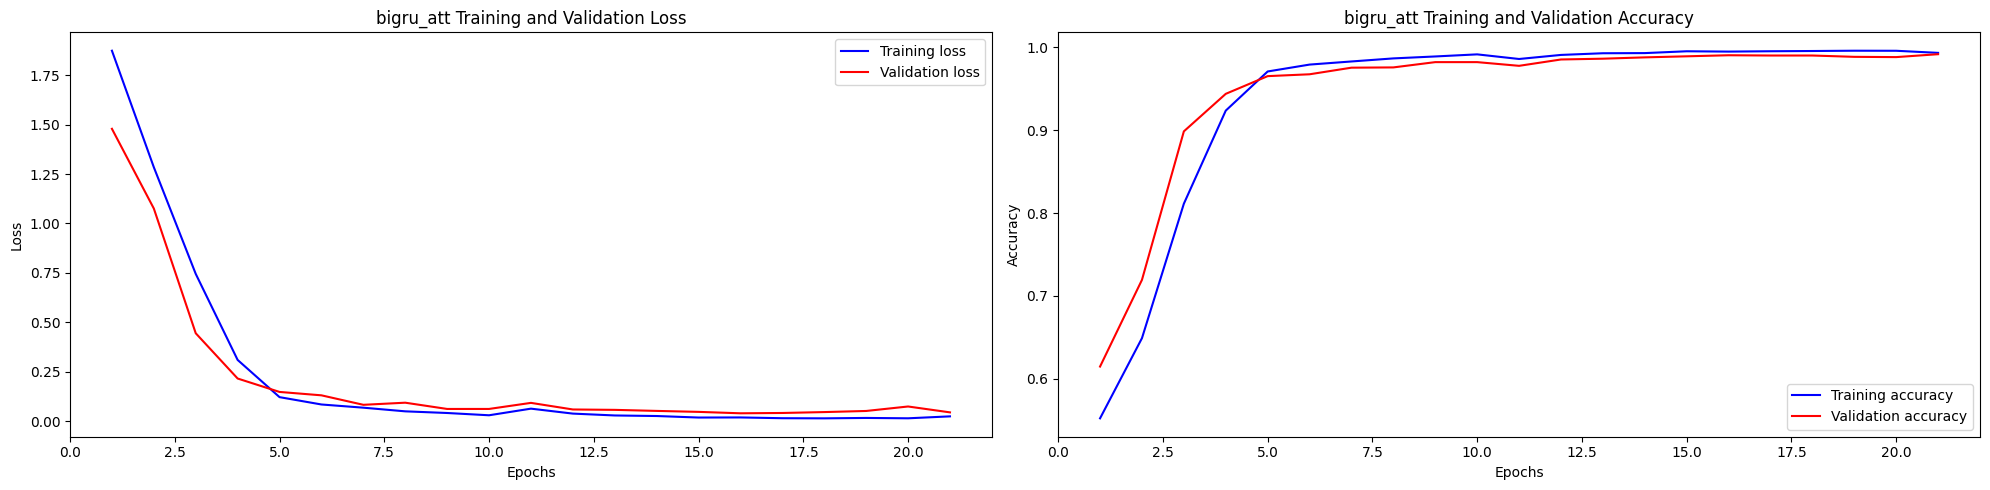

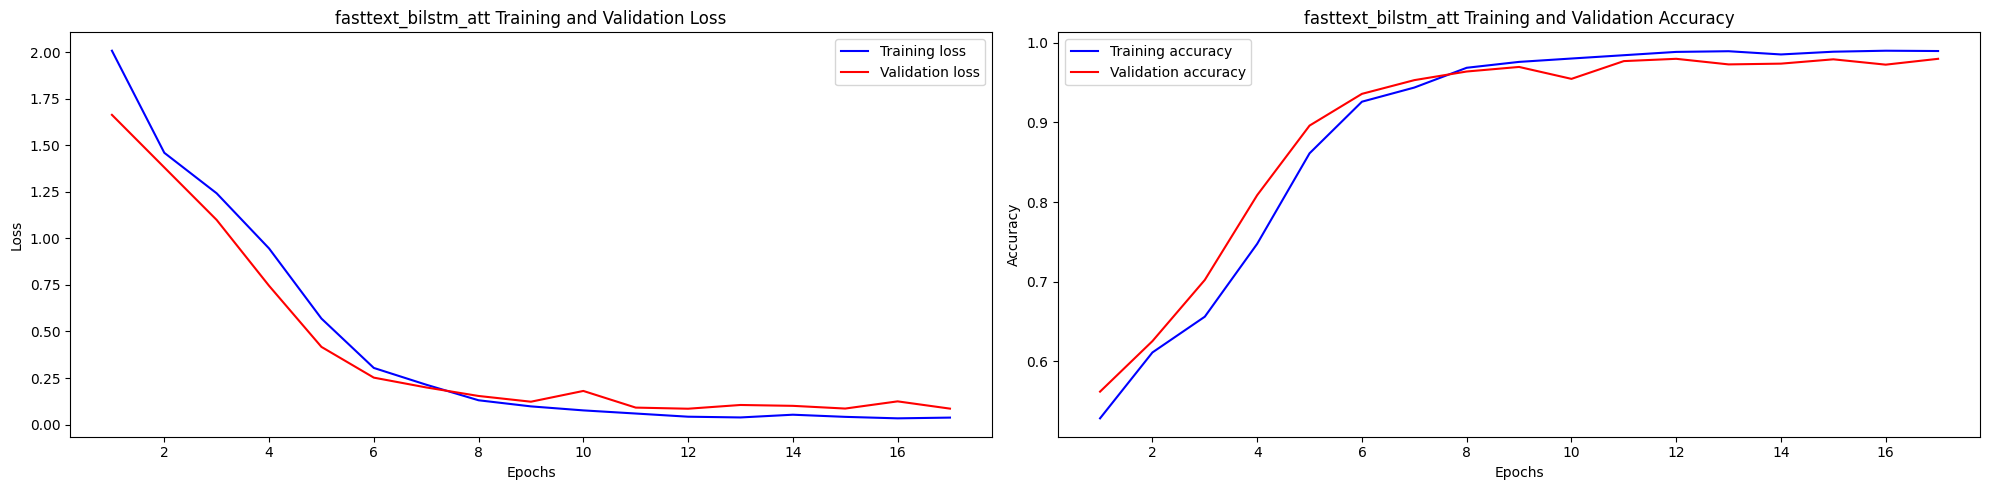

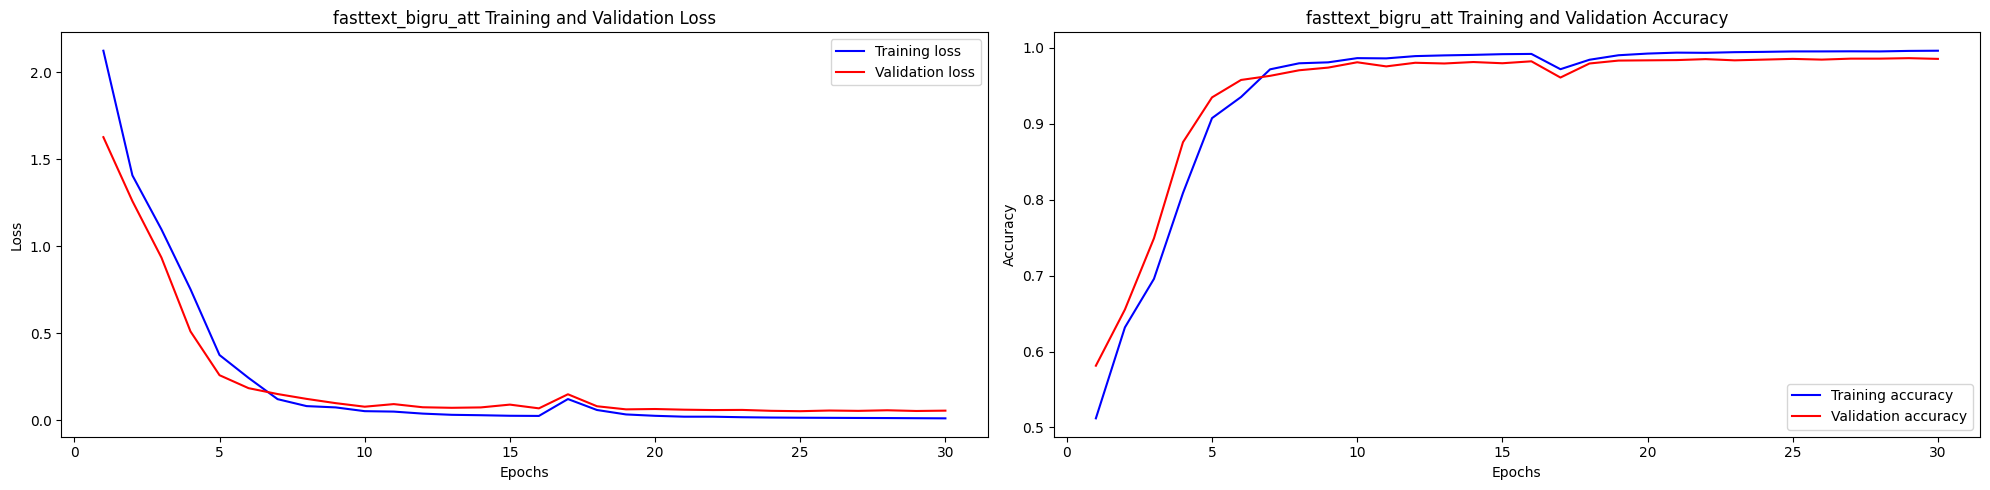

In [ ]:
'''
Plot Accuracy and Loss
'''

histories = {
    'bilstm_att': bilstm_att_history,
    'bigru_att': bigru_att_history,
    'fasttext_bilstm_att': fasttext_bilstm_att_history,
    'fasttext_bigru_att': fasttext_bigru_att_history
}

for model_name, history in histories.items():
    plot_loss_accuracy(model_name, history)

In [ ]:
'''
Save model
'''

filename = 'fasttext_bilstm_att_5.pkl'
pickle.dump(fasttext_bilstm_att, open(filename, 'wb'))
files.download('fasttext_bilstm_att_5.pkl')

filename = 'fasttext_bigru_att_5.pkl'
pickle.dump(fasttext_bigru_att, open(filename, 'wb'))
files.download('fasttext_bigru_att_5.pkl')

filename = 'bilstm_att_5.pkl'
pickle.dump(bilstm_att, open(filename, 'wb'))
files.download('bilstm_att_5.pkl')

filename = 'bigru_att_5.pkl'
pickle.dump(bigru_att, open(filename, 'wb'))
files.download('bigru_att_5.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def decode_output(decoder_input, tokenizer):
    output_seq = decoder_input[0, 1:-1]
    predicted_text = ""
    for index in output_seq:
        if index == 0:
            continue
        predicted_char = tokenizer.index_word.get(index, '')
        if predicted_char != ' ':
            predicted_text += predicted_char
    return predicted_text

In [ ]:
def predict_latin(input_sequences, model, pegon_tokenizer, latin_tokenizer , pegon_max_length, latin_max_length):
    predictions = []
    for input_sequence in input_sequences:
        encoder_input = np.array([input_sequence])
        decoder_input = np.zeros((1, latin_max_length))
        decoder_input[0, 0] = latin_tokenizer.word_index['\t']

        for i in range(1, latin_max_length):
            pred = model.predict([[encoder_input], decoder_input], verbose=0)[0]
            predicted_token_index = np.argmax(pred[i-1])
            decoder_input[0, i] = predicted_token_index
            if predicted_token_index == latin_tokenizer.word_index['\n']:
                break

        predicted_text = decode_output(decoder_input, latin_tokenizer)
        predictions.append(predicted_text)
    return predictions

In [ ]:
'''
Predict Data Train
'''

fasttext_bilstm_att_pred = predict_latin(X_val, fasttext_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
fasttext_bigru_att_pred = predict_latin(X_val, fasttext_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bilstm_att_pred = predict_latin(X_val, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_pred = predict_latin(X_val, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis

In [ ]:
'''
Get The Latin and Pegon of Data Train
'''

pegon_train, pegon_test, latin_train, latin_test = train_test_split(train_df['pegon'], train_df['latin'], test_size=0.1, random_state=42)

In [ ]:
def calculate_cer(row):
    # Calculate Levenshtein distance between Ground Truth and Predicted strings
    distance = levenshtein_distance(row['Ground Truth'], row['Predicted'])

    # Calculate the length of the target (Ground Truth) string
    length = len(row['Ground Truth'])

    # Calculate CER (Character Error Rate) and handle the case when the length is 0
    return distance / length if length > 0 else np.nan

In [ ]:
def create_cer_analysis(result_df):
    # Remove '\n' and '\t' from the dataframe
    result_df = result_df.replace(r'\n', '', regex=True).replace(r'\t', '', regex=True)

    # Calculate CER for each row
    result_df['CER'] = result_df.apply(calculate_cer, axis=1)

    # Calculate mean CER
    cer_mean = result_df['CER'].mean()

    # Filter rows with CER > 0
    error_result = result_df[result_df['CER'] > 0]

    return result_df, cer_mean, error_result

## BiLSTM-Att

In [ ]:
'''
Calculate CER
'''

bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_pred
})

bilstm_att_result, bilstm_att_cer, bilstm_att_error_result = create_cer_analysis(bilstm_att_result)

print("Average CER: " + str(bilstm_att_cer))

Average CER: 0.028589032495282496


In [ ]:
'''
Prediction Result
'''

bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
1569,بَاڮِىْ,bagi,bagi,0.000000
1756,تَنْفَا,tanpa,tanfa,0.200000
1628,ڮُوْنُوْڠ٢,gunuṅ2,gunuṅ2,0.000000
39,الْاَعْمَالِ,al-a'mali,al-a'mali,0.000000
1289,ڠَاسْطَا,ṅasṯa,ṅasṯa,0.000000
...,...,...,...,...
2,سڠا,sṅa,saṅ,0.666667
1673,اِنْࢮِيْسࣤى,inḍisě,inḍis,0.166667
1505,ڠُوْسِيْر,ṅusir,ṅusir,0.000000
312,مࣤدُوْرَا,mědura,mědura,0.000000


In [ ]:
'''
Error Result
'''

bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
1756,تَنْفَا,tanpa,tanfa,0.200000
3152,بَفَائَىْ,bafae,bapa`e,0.400000
1275,عَلَّامَةْ,'allamah,'allamat,0.125000
249,مَشْهُوْر,maśhur,maśuhr,0.333333
3180,دُعَاءَاكَىْ,du'a`ake,du'aake,0.125000
442,نِزَارْ,nizar,niḏar,0.200000
1540,١٥٨٦م,1586m,1588m,0.200000
1665,مُحَمَّدِيَّهْ,muẖammadiyyah,muẖammadiyah,0.076923
97,الاَئِمَّةِ,al-aimmati,al-aimati,0.100000
2925,فُوڠْكَاسَانَىْ,fuṅkasane,puṅkasane,0.111111


## BiGRU-Att

In [ ]:
bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_pred
})

bigruatt_result, bigru_att_cer, bigru_att_error_result = create_cer_analysis(bigru_att_result)

print("Average CER: " + str(bigru_att_cer))

Average CER: 0.023562152133580705


In [ ]:
'''
Prediction Result
'''

bigruatt_result

,Pegon,Ground Truth,Predicted,CER
1569,بَاڮِىْ,bagi,bagi,0.000000
1756,تَنْفَا,tanpa,tanfa,0.200000
1628,ڮُوْنُوْڠ٢,gunuṅ2,gunuṅ2,0.000000
39,الْاَعْمَالِ,al-a'mali,al-a'mali,0.000000
1289,ڠَاسْطَا,ṅasṯa,ṅasṯa,0.000000
...,...,...,...,...
2,سڠا,sṅa,sa,0.333333
1673,اِنْࢮِيْسࣤى,inḍisě,inḍisě,0.000000
1505,ڠُوْسِيْر,ṅusir,ṅusir,0.000000
312,مࣤدُوْرَا,mědura,mědura,0.000000


In [ ]:
'''
Error Result
'''

bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
1756,تَنْفَا,tanpa,tanfa,0.200000
1196,سࣤنَجَانْ,sěnajan,sěnan,0.285714
1538,فُوْڠكَاسَانَىْ,puṅkasane,fuṅkasane,0.111111
306,فُوْتࣤرِىْ,putěri,futěri,0.166667
1096,فَارِيْڠَاكَىْ,pariṅake,fariṅake,0.125000
1275,عَلَّامَةْ,'allamah,'allamat,0.125000
40,الصَّالِحَةِ,aṣ-ṣaliẖati,ṣṣ-ṣaliẖati,0.090909
3180,دُعَاءَاكَىْ,du'a`ake,du'aake,0.125000
1540,١٥٨٦م,1586m,1586,0.200000
65,يُعَلِّمُنَا,yu'allimuna,yu'limuna,0.181818


## fastText BiLSTM-Att

In [ ]:
fasttext_bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bilstm_att_pred
})

fasttext_bilstm_att_result, fasttext_bilstm_att_cer, fasttext_bilstm_att_error_result = create_cer_analysis(fasttext_bilstm_att_result)

print("Average CER: " + str(fasttext_bilstm_att_cer))

Average CER: 0.0525208422529851


In [ ]:
'''
Prediction Result
'''

fasttext_bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
1569,بَاڮِىْ,bagi,bagi,0.000000
1756,تَنْفَا,tanpa,tanfa,0.200000
1628,ڮُوْنُوْڠ٢,gunuṅ2,gunuṅ2,0.000000
39,الْاَعْمَالِ,al-a'mali,ala'mali,0.111111
1289,ڠَاسْطَا,ṅasṯa,ṅasṯa,0.000000
...,...,...,...,...
2,سڠا,sṅa,sěṅ,0.666667
1673,اِنْࢮِيْسࣤى,inḍisě,inḍisě,0.000000
1505,ڠُوْسِيْر,ṅusir,ṅusir,0.000000
312,مࣤدُوْرَا,mědura,mědura,0.000000


In [ ]:
'''
Error Result
'''

fasttext_bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
1756,تَنْفَا,tanpa,tanfa,0.200000
39,الْاَعْمَالِ,al-a'mali,ala'mali,0.111111
2711,تَوْبَةً,tobatan,tobatta,0.285714
1609,٢٨,28,23,0.500000
889,٧,7,1,1.000000
907,١٦,16,10,0.500000
1441,١٤٥٣,1453,1970,0.750000
1096,فَارِيْڠَاكَىْ,pariṅake,fariṅake,0.125000
1275,عَلَّامَةْ,'allamah,'allamat,0.125000
330,اِيَا,ia,iya,0.500000


## fastText BiGRU-Att

In [ ]:
fasttext_bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bigru_att_pred
})

fasttext_bigruatt_result, fasttext_bigru_att_cer, fasttext_bigru_att_error_result = create_cer_analysis(fasttext_bigru_att_result)

print("Average CER: " + str(fasttext_bigru_att_cer))

Average CER: 0.04217364976293547


In [ ]:
'''
Prediction Result
'''

fasttext_bigruatt_result

,Pegon,Ground Truth,Predicted,CER
1569,بَاڮِىْ,bagi,bagi,0.000000
1756,تَنْفَا,tanpa,tanfa,0.200000
1628,ڮُوْنُوْڠ٢,gunuṅ2,gunuṅ2,0.000000
39,الْاَعْمَالِ,al-a'mali,al-a'mali,0.000000
1289,ڠَاسْطَا,ṅasṯa,ṅasṯa,0.000000
...,...,...,...,...
2,سڠا,sṅa,ssṅ,0.666667
1673,اِنْࢮِيْسࣤى,inḍisě,inḍisě,0.000000
1505,ڠُوْسِيْر,ṅusir,ṅusir,0.000000
312,مࣤدُوْرَا,mědura,mědura,0.000000


In [ ]:
'''
Error Result
'''

fasttext_bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
1756,تَنْفَا,tanpa,tanfa,0.200000
1609,٢٨,28,23,0.500000
889,٧,7,3,1.000000
907,١٦,16,13,0.500000
1441,١٤٥٣,1453,1547,0.750000
1096,فَارِيْڠَاكَىْ,pariṅake,fariṅake,0.125000
1275,عَلَّامَةْ,'allamah,'allamat,0.125000
249,مَشْهُوْر,maśhur,maśur,0.166667
3180,دُعَاءَاكَىْ,du'a`ake,du'aake,0.125000
1540,١٥٨٦م,1586m,1548m,0.400000


## CER Compare

In [ ]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'fasttext_bilstm_att', 'fasttext_bigru_att'],
    'CER': [bilstm_att_cer, bigru_att_cer, fasttext_bilstm_att_cer, fasttext_bigru_att_cer]
})

cer_result

,Model,CER
0,bilstm_att,0.028589
1,bigru_att,0.023562
2,fasttext_bilstm_att,0.052521
3,fasttext_bigru_att,0.042174


# Model Testing

In [ ]:
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(test_df['pegon'], pegon_tokenizer)

In [ ]:
best_model = bigru_att
pred = predict_latin(padded_pegon, best_model, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

In [ ]:
result = pd.DataFrame({
    'Pegon': test_df['pegon'],
    'Ground Truth': test_df['latin'],
    'Predicted': pred
})

model_result, model_cer, model_error_result = create_cer_analysis(result)

print("Average CER: " + str(model_cer))

Average CER: 0.04264692246619957


In [ ]:
model_result

,Pegon,Ground Truth,Predicted,CER
1544,١٦١٣,1613,1911,0.500000
1308,مࣤرَيْنتَهَاكࣤنْ,měrentahakěn,měrentahakěn,0.000000
1091,دَامَارْ,damar,damar,0.000000
1359,فَرَاجُوْرِيْت,parajurit,farajurit,0.111111
3022,چࣤطِيلْ,cěṯil,cěṯil,0.000000
...,...,...,...,...
1864,فَانْ,fan,pan,0.333333
1163,سࣤكَابَيْهَانَىْ,sěkabehane,sěkabehane,0.000000
218,جُوْمࣤنࣤڠْ,juměněṅ,juměněṅ,0.000000
3160,تُوْمَا,tuma,tuma,0.000000


In [ ]:
model_error_result

,Pegon,Ground Truth,Predicted,CER
1544,١٦١٣,1613,1911,0.500000
1359,فَرَاجُوْرِيْت,parajurit,farajurit,0.111111
1476,فࣤفࣤرَاڠَانْ,pěpěraṅan,pěfěraṅan,0.111111
188,كࣤفَيْڠِيْن,kěpeṅin,kěfeṅin,0.142857
1419,مَشَارَكَةْ,maśarakat,maśarakah,0.111111
1054,كَافࣤرِيْيَىْ,kapěriye,kafěrie,0.250000
965,٦٣٣,633,1333,0.666667
1578,ڮࣤڮࣤلَارْ,gěgělar,gělělar,0.142857
485,سُوْرَابَيَا,surabaya,surabea,0.250000
819,رُوْفَا,rupa,rufa,0.250000
